# Sampling crvUSD Liquidity from Historical Data

We examine the historical crvUSD liquidity in the relevant stableswap pools. Notice that there are three kinds of liquidity in our simulations:

1. collateral and crvUSD in LLAMMAs <- simulated using randomly sampled debt positions (see `demo_borrowers.ipynb`).
2. crvUSD debt in StableSwap pools <- TODO (see this notebook).
3. Liquidity on "External Markets" <- simulated using an Isotonic Regressor trained on historical 1Inch quotes (see `demo_slippage_curves.ipynb`).

In [1]:
import numpy as np
import scipy.stats as stats
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
from src.utils import (
    get_historical_user_snapshots,
    get_historical_stableswap_stats,
    group_user_states,
)
from src.plotting.sim import plot_debt_to_liquidity
from src.configs import (
    LLAMMA_ALIASES,
    STABLESWAP_ADDRESSES,
    STABLESWAP_ALIASES,
    CRVUSD_USDC_ADDRESS,
    CRVUSD_TUSD_ADDRESS,
    CRVUSD_USDT_ADDRESS,
    CRVUSD_USDP_ADDRESS,
)

%load_ext autoreload
%autoreload 2

In [2]:
def plot_liquidity_over_time(df):
    df["peg"].plot(label="peg")
    df["crvUSD"].plot(label="crvUSD")
    df["supply"].plot(label="supply")
    plt.legend()
    plt.show()


def plot_liquidity_distribution(df):
    f, axs = plt.subplots(1, 3, figsize=(15, 5))
    df["peg"].hist(grid=False, bins=25, ax=axs[0])
    axs[0].set_title("Peg Coin Distribution")
    df["crvUSD"].hist(grid=False, bins=25, ax=axs[1])
    axs[1].set_title("crvUSD Distribution")
    df["supply"].hist(grid=False, bins=25, ax=axs[2])
    axs[2].set_title("Total Supply Distribution")
    plt.show()


def probplot(df):
    f, axs = plt.subplots(1, 2)
    stats.probplot(df["peg"], dist="norm", plot=axs[0])
    axs[0].set_title("Peg Coin Balance")
    stats.probplot(df["crvUSD"], dist="norm", plot=axs[1])
    axs[1].set_title("crvUSD Balance")
    plt.show()

In [3]:
start = int(datetime(2023, 10, 1).timestamp())
end = int(datetime(2024, 1, 1).timestamp())

dfs = get_historical_stableswap_stats(STABLESWAP_ADDRESSES, start, end)

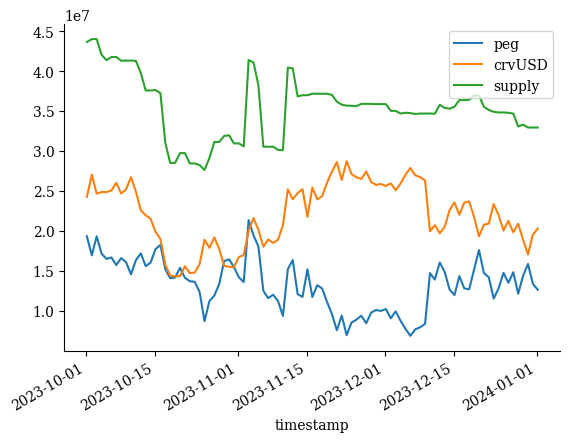

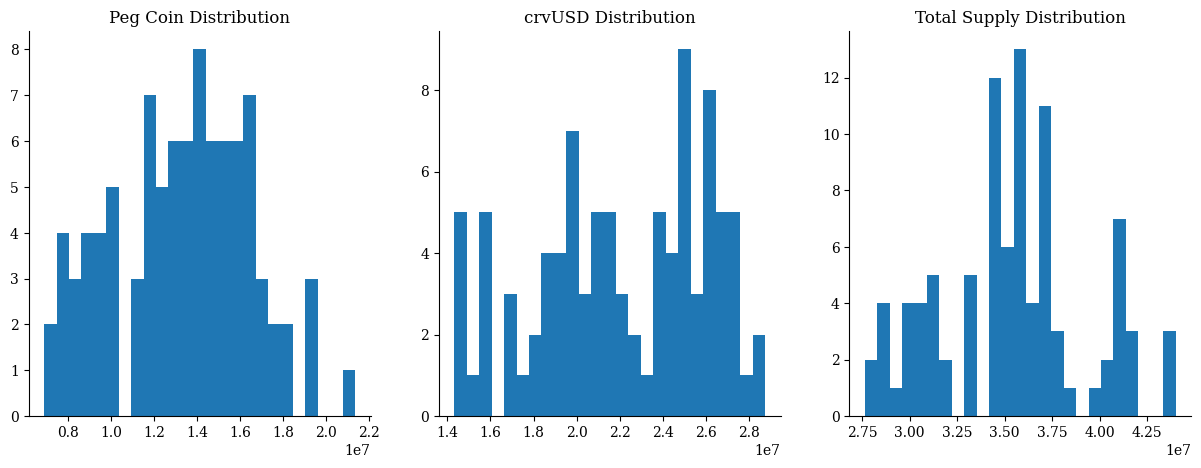

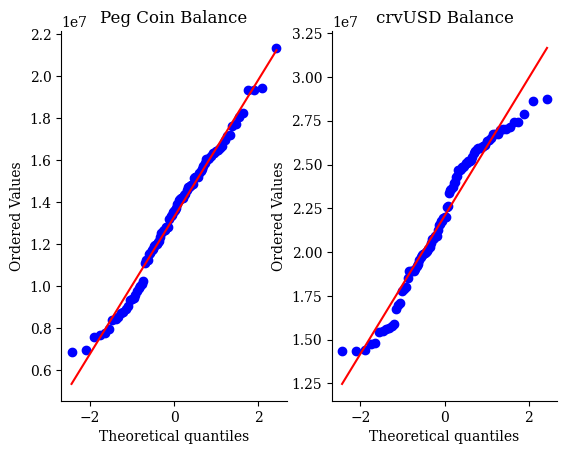

In [4]:
df = dfs[CRVUSD_USDC_ADDRESS]
plot_liquidity_over_time(df)
plot_liquidity_distribution(df)
probplot(df)

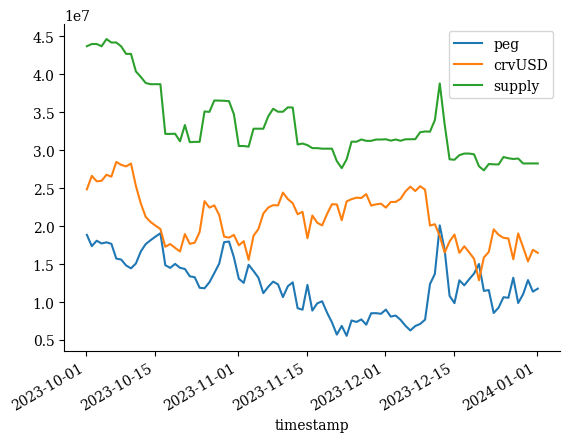

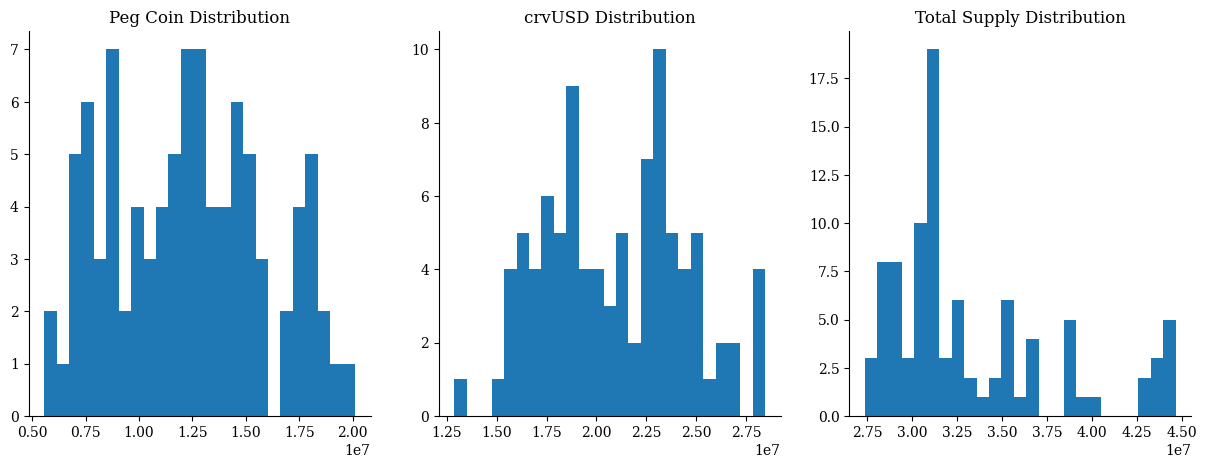

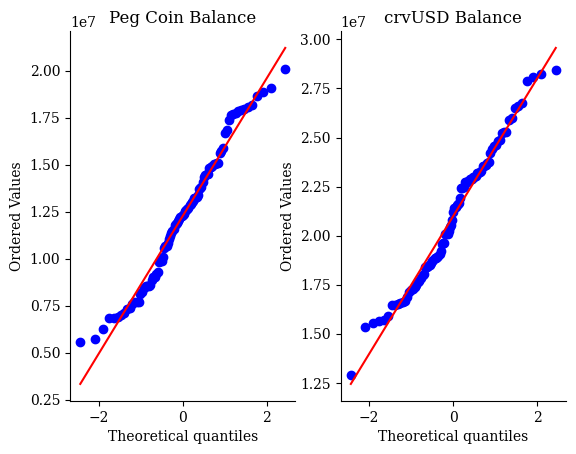

In [5]:
df = dfs[CRVUSD_USDT_ADDRESS]
plot_liquidity_over_time(df)
plot_liquidity_distribution(df)
probplot(df)

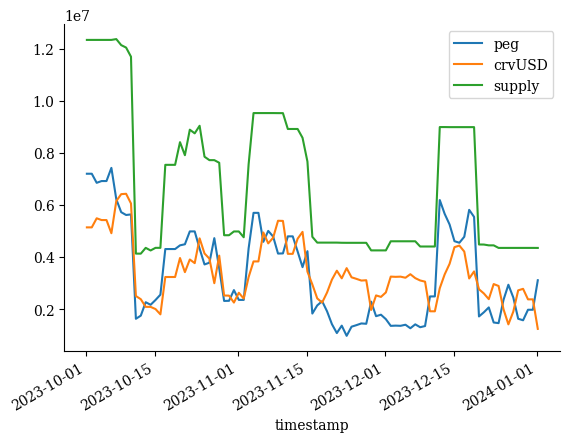

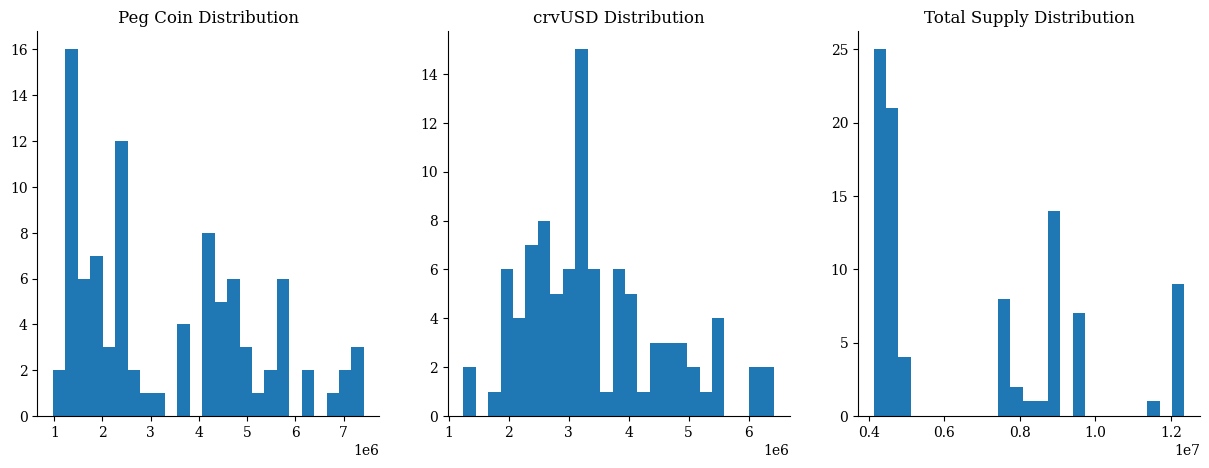

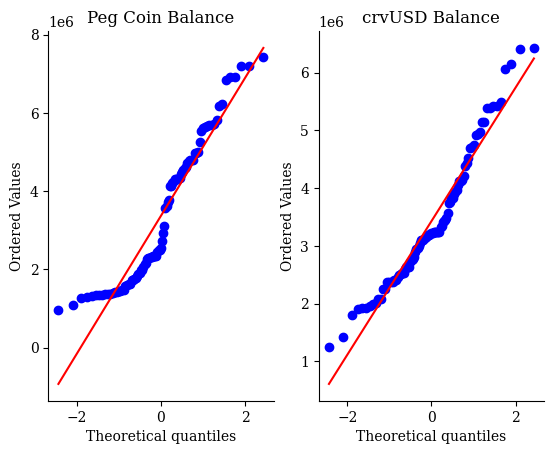

In [6]:
df = dfs[CRVUSD_TUSD_ADDRESS]
plot_liquidity_over_time(df)
plot_liquidity_distribution(df)
probplot(df)

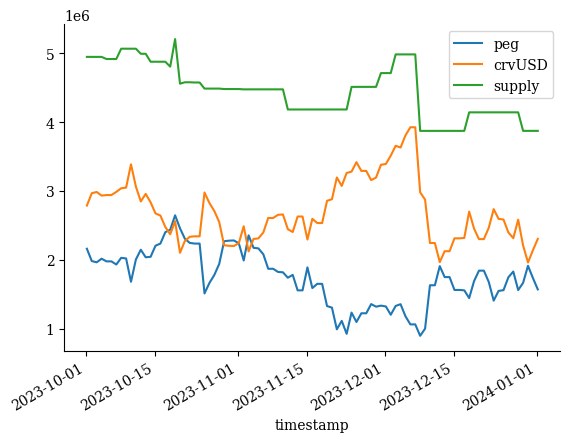

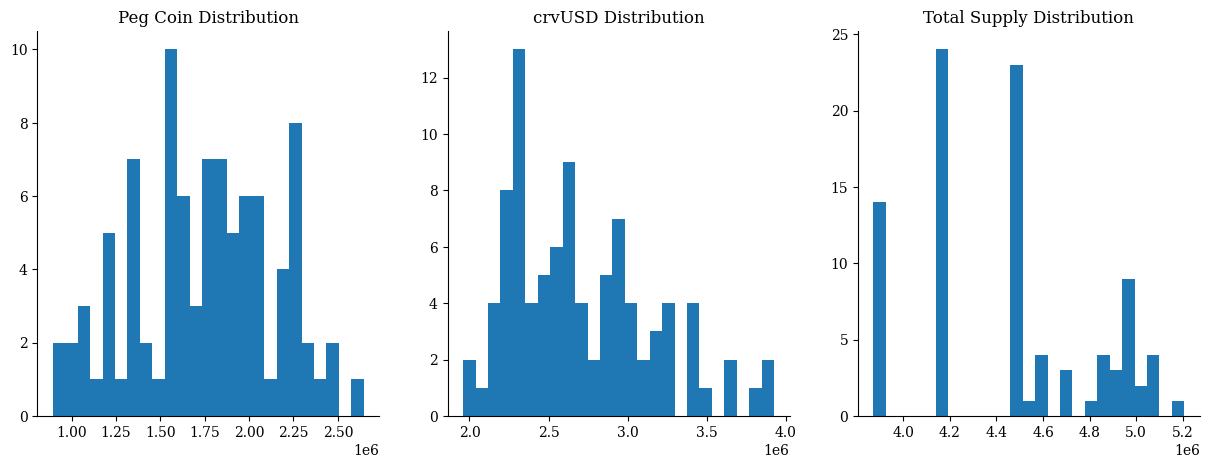

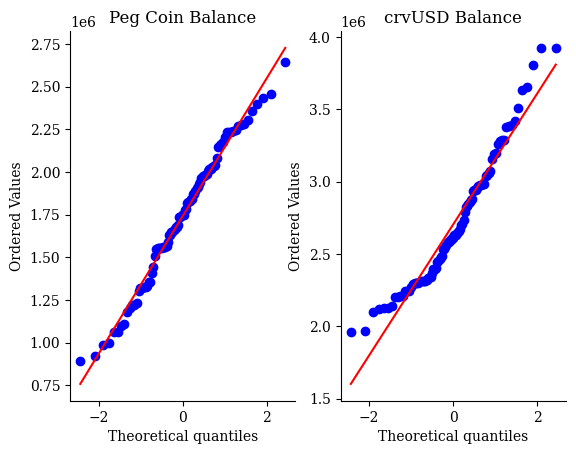

In [7]:
df = dfs[CRVUSD_USDP_ADDRESS]
plot_liquidity_over_time(df)
plot_liquidity_distribution(df)
probplot(df)

In [8]:
df = dfs[CRVUSD_USDC_ADDRESS]
data = df[["peg", "crvUSD"]].values

# Estimate parameters
mean_vector = np.mean(data, axis=0)
covariance_matrix = np.cov(data, rowvar=False)

# Sample from the joint distribution
num_samples = 1000
samples = np.random.multivariate_normal(mean_vector, covariance_matrix, num_samples)

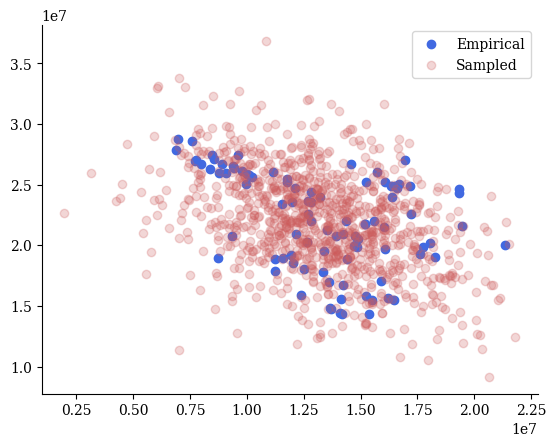

In [9]:
plt.scatter(data.T[0], data.T[1], color="royalblue", label="Empirical")
plt.scatter(samples.T[0], samples.T[1], color="indianred", label="Sampled", alpha=0.25)
plt.legend()

In [10]:
aliases = ["wsteth", "weth", "wbtc", "sfrxeth"]
grouped_data = []
for alias in aliases:
    market = LLAMMA_ALIASES[alias]
    user_states = get_historical_user_snapshots(market, start, end)
    grouped_data.append(group_user_states(user_states))

In [11]:
debts = pd.DataFrame(
    [
        df.rename(columns={"debt": alias})[alias]
        for alias, df in zip(aliases, grouped_data)
    ]
).T
debts["debt"] = debts.sum(axis=1)
debts = debts.resample("1d").mean()
debts.head()

,wsteth,weth,wbtc,sfrxeth,debt
datetime,,,,,
2023-09-30,4.195846e+07,5.762736e+06,4.389156e+07,9.231491e+06,1.008442e+08
2023-10-01,4.273815e+07,5.757250e+06,4.395752e+07,9.261179e+06,1.017141e+08
2023-10-02,4.292228e+07,6.207339e+06,4.335811e+07,9.079936e+06,1.015677e+08
2023-10-03,4.069514e+07,6.170375e+06,4.701885e+07,1.000663e+07,1.038910e+08
2023-10-04,4.056311e+07,6.148231e+06,4.705074e+07,1.001299e+07,1.037751e+08


In [12]:
liquidity = pd.DataFrame(
    [
        df.rename(columns={"crvUSD": STABLESWAP_ALIASES[address]})[
            STABLESWAP_ALIASES[address]
        ]
        for address, df in dfs.items()
    ]
).T
liquidity["liquidity"] = liquidity.sum(axis=1)
liquidity = liquidity.resample("1d").mean()
liquidity.head()

,usdc_stableswap,usdt_stableswap,tusd_stableswap,usdp_stableswap,liquidity
timestamp,,,,,
2023-10-01,2.429347e+07,2.485379e+07,5.136401e+06,2.787582e+06,5.707124e+07
2023-10-02,2.704362e+07,2.663157e+07,5.136401e+06,2.966675e+06,6.177826e+07
2023-10-03,2.467229e+07,2.591386e+07,5.484620e+06,2.985026e+06,5.905579e+07
2023-10-04,2.487149e+07,2.598123e+07,5.416854e+06,2.932290e+06,5.920186e+07
2023-10-05,2.486477e+07,2.677640e+07,5.416854e+06,2.940335e+06,5.999836e+07


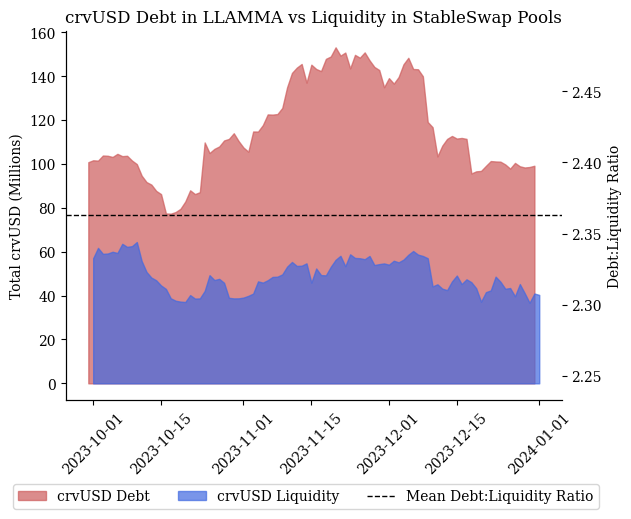

In [23]:
_ = plot_debt_to_liquidity(debts, liquidity)

In [14]:
ratio = (debts["debt"] / liquidity["liquidity"]).dropna()
ratio.describe()

count    92.000000
mean      2.362817
std       0.362057
min       1.551653
25%       2.169457
50%       2.440397
75%       2.606633
max       3.164624
dtype: float64

In [15]:
target_ratio = ratio.mean()
total_debt = debts["debt"].iloc[-1]  # the sampled debt (from the resampling)
total_debt, target_ratio

(99219673.62583779, 2.362817493702465)

In [16]:
scale_factor = total_debt / (target_ratio * liquidity["liquidity"].mean())
scale_factor  # scale factor required to center liquidity given sampled debt

0.8534813891066512

In [17]:
covariance_matrix.tolist()

[[10444039839852.707, -5343676995232.574],
 [-5343676995232.574, 15676536217749.545]]

In [18]:
num_samples = 100
sampled_liquidity = []
config = {}
for address, df in dfs.items():
    data = df[["peg", "crvUSD"]].values
    # Estimate parameters
    mean_vector = np.mean(data, axis=0) * scale_factor  # scale mean vector
    covariance_matrix = np.cov(data, rowvar=False)
    # Sample from the joint distribution
    samples = np.random.multivariate_normal(mean_vector, covariance_matrix, num_samples)
    sampled_liquidity.append(samples.T[1])

    config[address] = {
        "mean_vector": np.mean(data, axis=0).tolist(),
        "covariance_matrix": covariance_matrix.tolist(),
    }

config["target_ratio"] = target_ratio

sampled_liquidity = np.array(sampled_liquidity)
sampled_liquidity.shape

(4, 100)

In [19]:
aliases = [STABLESWAP_ALIASES[address] for address in dfs.keys()]
sampled_liquidity_df = pd.DataFrame(sampled_liquidity.T, columns=aliases)
sampled_liquidity_df["liquidity"] = sampled_liquidity_df.sum(axis=1)
sampled_liquidity_df["ratio"] = total_debt / sampled_liquidity_df["liquidity"]
sampled_liquidity_df.head()

,usdc_stableswap,usdt_stableswap,tusd_stableswap,usdp_stableswap,liquidity,ratio
0,1.592477e+07,1.432696e+07,4.448677e+06,2.049725e+06,3.675014e+07,2.699845
1,2.186961e+07,1.533016e+07,3.938570e+06,2.955081e+06,4.409343e+07,2.250214
2,1.378093e+07,1.630641e+07,4.512985e+06,2.372912e+06,3.697324e+07,2.683554
3,1.389506e+07,1.239223e+07,3.019622e+06,1.763769e+06,3.107068e+07,3.193353
4,2.149977e+07,2.239249e+07,4.751717e+06,2.419280e+06,5.106326e+07,1.943074


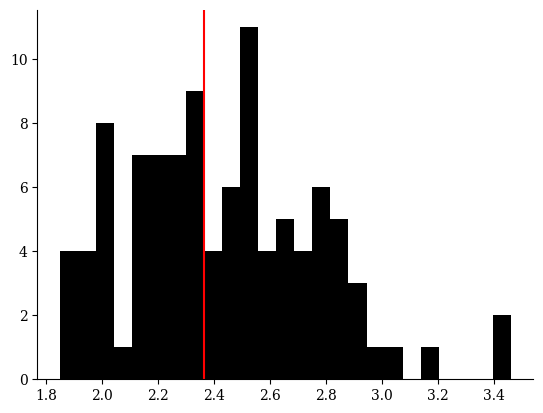

In [20]:
f, ax = plt.subplots()

sampled_liquidity_df["ratio"].hist(
    grid=False, bins=num_samples // 4, ax=ax, color="black"
)
ax.axvline(target_ratio, color="red", label="target ratio", c="red")

In [21]:
config

{'0x4dece678ceceb27446b35c672dc7d61f30bad69e': {'mean_vector': [13301725.774722604,
   22063704.151237566],
  'covariance_matrix': [[10444039839852.707, -5343676995232.574],
   [-5343676995232.574, 15676536217749.545]]},
 '0x390f3595bca2df7d23783dfd126427cceb997bf4': {'mean_vector': [12270429.929307098,
   21005844.782402404],
  'covariance_matrix': [[13307829192532.402, -1488878431113.9937],
   [-1488878431113.9937, 12190509648961.377]]},
 '0x34d655069f4cac1547e4c8ca284ffff5ad4a8db0': {'mean_vector': [3366878.6913696276,
   3426015.4241633415],
  'covariance_matrix': [[3290548249887.2573, 1454808246855.219],
   [1454808246855.219, 1355928295052.5437]]},
 '0xca978a0528116dda3cba9acd3e68bc6191ca53d0': {'mean_vector': [1742667.0215639863,
   2705393.8762533944],
  'covariance_matrix': [[159751659439.31552, -110777988195.62952],
   [-110777988195.62952, 209304692955.21835]]},
 'target_ratio': 2.362817493702465}

In [22]:
import json

with open(f"../src/configs/liquidity/{start}_{end}.json", "w") as f:
    json.dump(config, f, indent=4)